# Million Song Dataset – Model Notebook

**Authors:** Shishi Jiang (u1583346)


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# Skip the first 9 lines of comments/metadata to reach the header
df = pd.read_csv('msd_genre_dataset.txt', skiprows=9)

# Rename the first column to 'genre' (it loads as '%genre')
df.rename(columns={df.columns[0]: 'genre'}, inplace=True)

## Exploratory Data Analysis (EDA)

I explore the class distribution and key audio features across genres using plots and summary statistics.


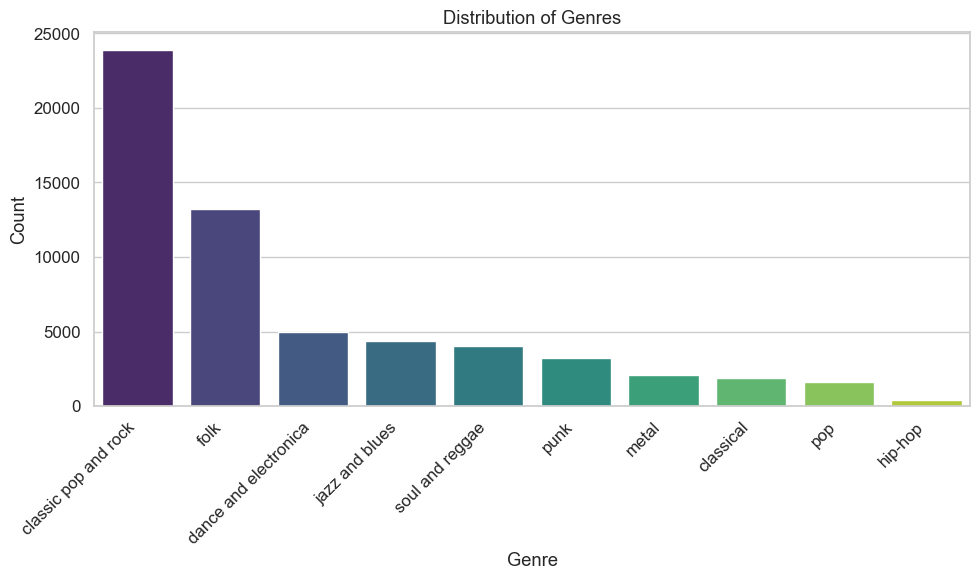

In [75]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='genre', order=df['genre'].value_counts().index, palette='viridis')
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

In [128]:
# Display the number of samples for each genre
genre_counts = df['genre'].value_counts()
print("Number of samples for each genre:")
print(genre_counts)

Number of samples for each genre:
genre
classic pop and rock     23895
folk                     13192
dance and electronica     4935
jazz and blues            4334
soul and reggae           4016
punk                      3200
metal                     2103
classical                 1874
pop                       1617
hip-hop                    434
Name: count, dtype: int64


In [93]:
print("Dataset Columns:", df.columns.tolist())


Dataset Columns: ['genre', 'track_id', 'artist_name', 'title', 'loudness', 'tempo', 'time_signature', 'key', 'mode', 'duration', 'avg_timbre1', 'avg_timbre2', 'avg_timbre3', 'avg_timbre4', 'avg_timbre5', 'avg_timbre6', 'avg_timbre7', 'avg_timbre8', 'avg_timbre9', 'avg_timbre10', 'avg_timbre11', 'avg_timbre12', 'var_timbre1', 'var_timbre2', 'var_timbre3', 'var_timbre4', 'var_timbre5', 'var_timbre6', 'var_timbre7', 'var_timbre8', 'var_timbre9', 'var_timbre10', 'var_timbre11', 'var_timbre12']


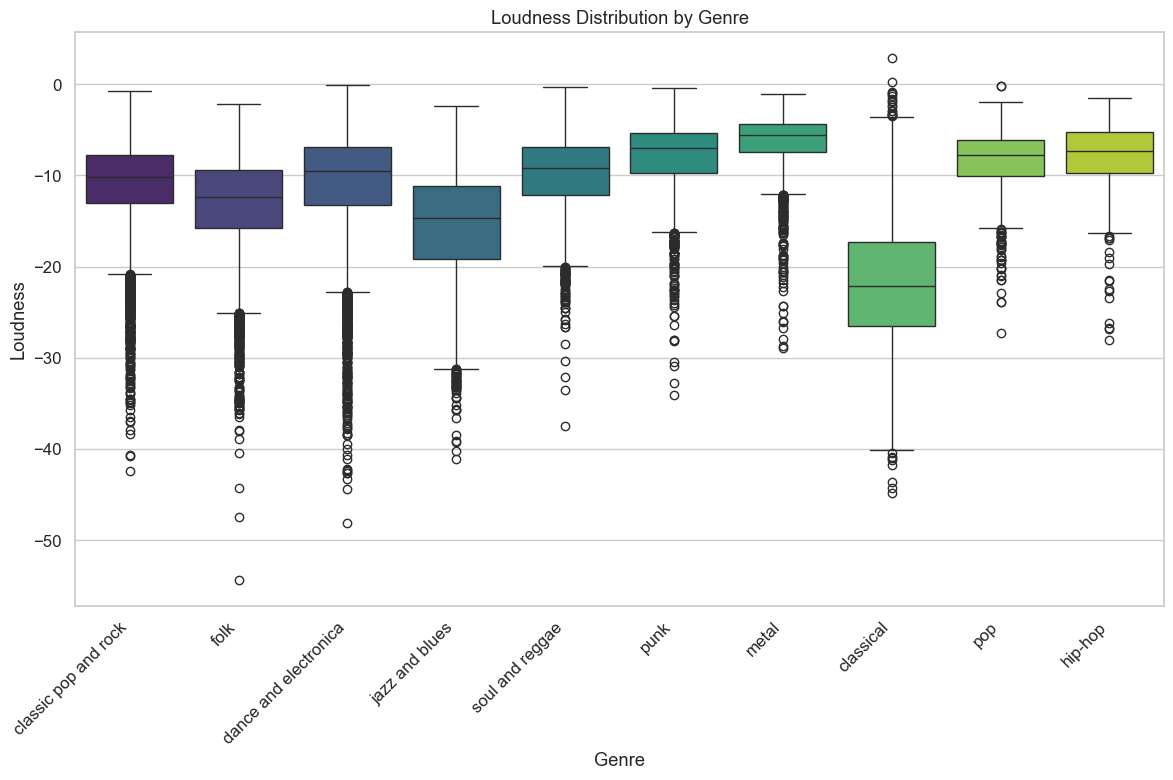

In [99]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='genre', y='loudness', order=df['genre'].value_counts().index, palette='viridis')
plt.title('Loudness Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Loudness')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


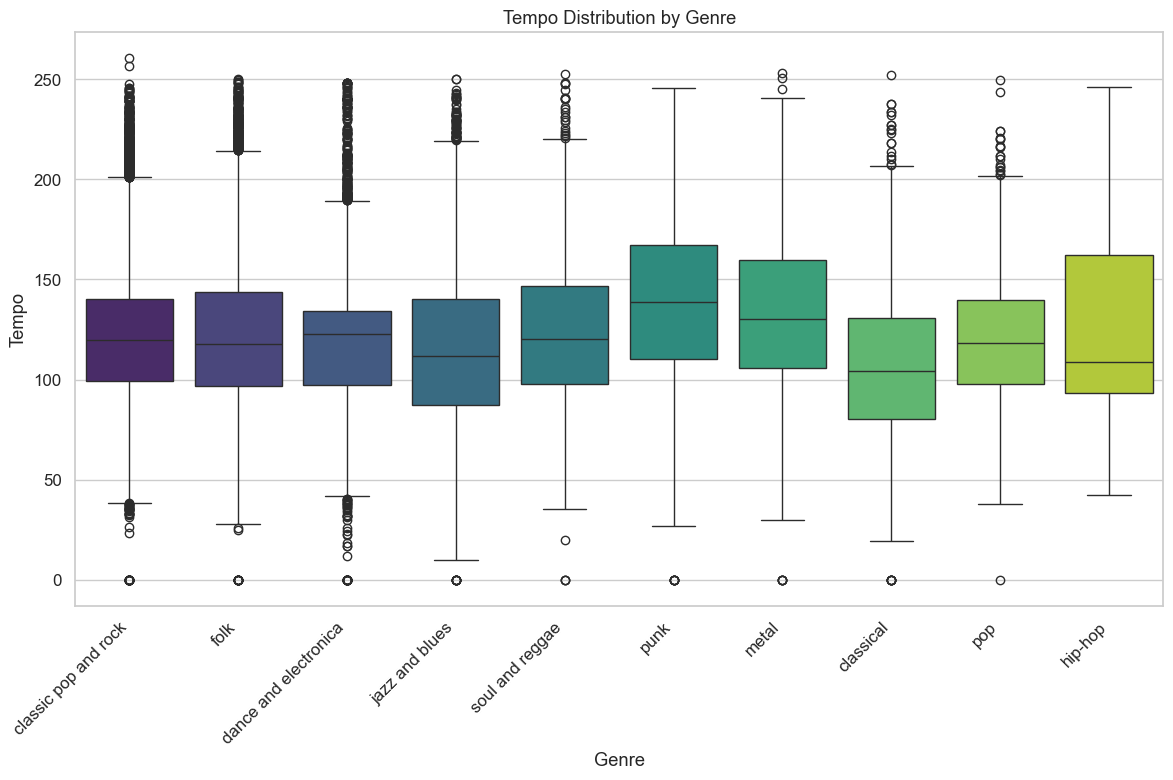

In [100]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='genre', y='tempo', order=df['genre'].value_counts().index, palette='viridis')
plt.title('Tempo Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Tempo')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

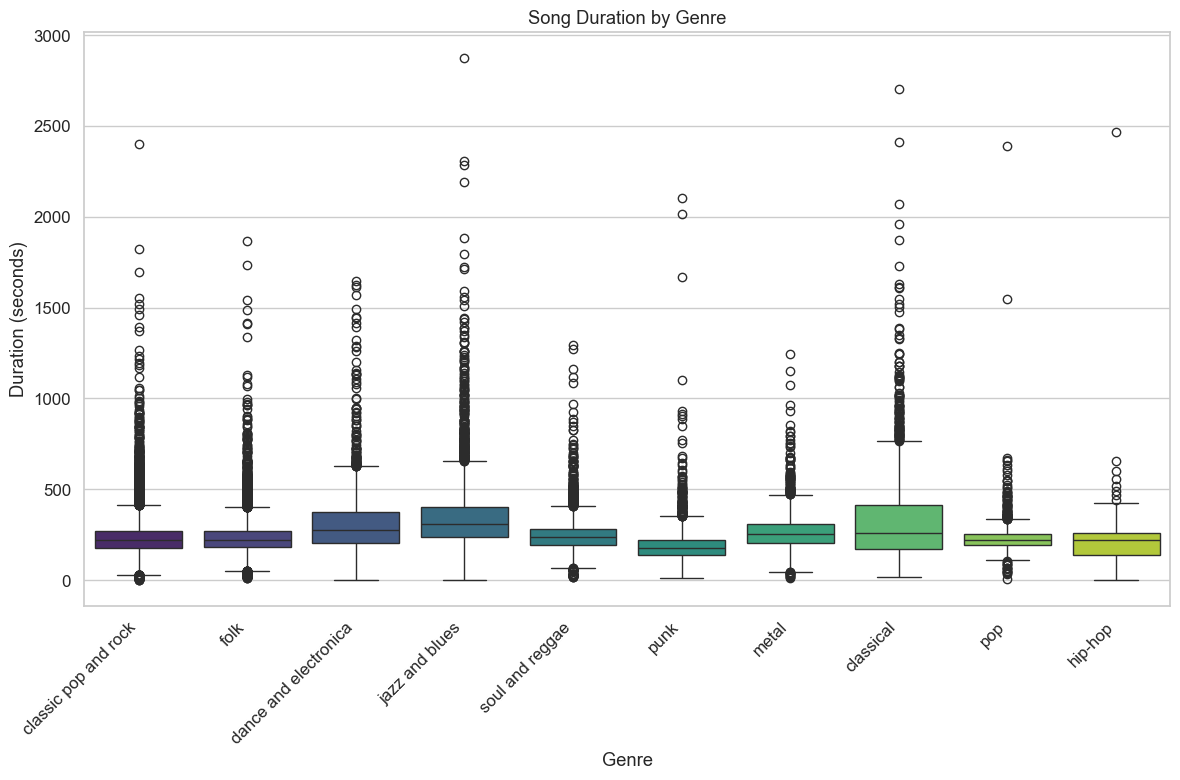

In [136]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='genre', y='duration', order=df['genre'].value_counts().index, palette='viridis')
plt.title('Song Duration by Genre')
plt.xlabel('Genre')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


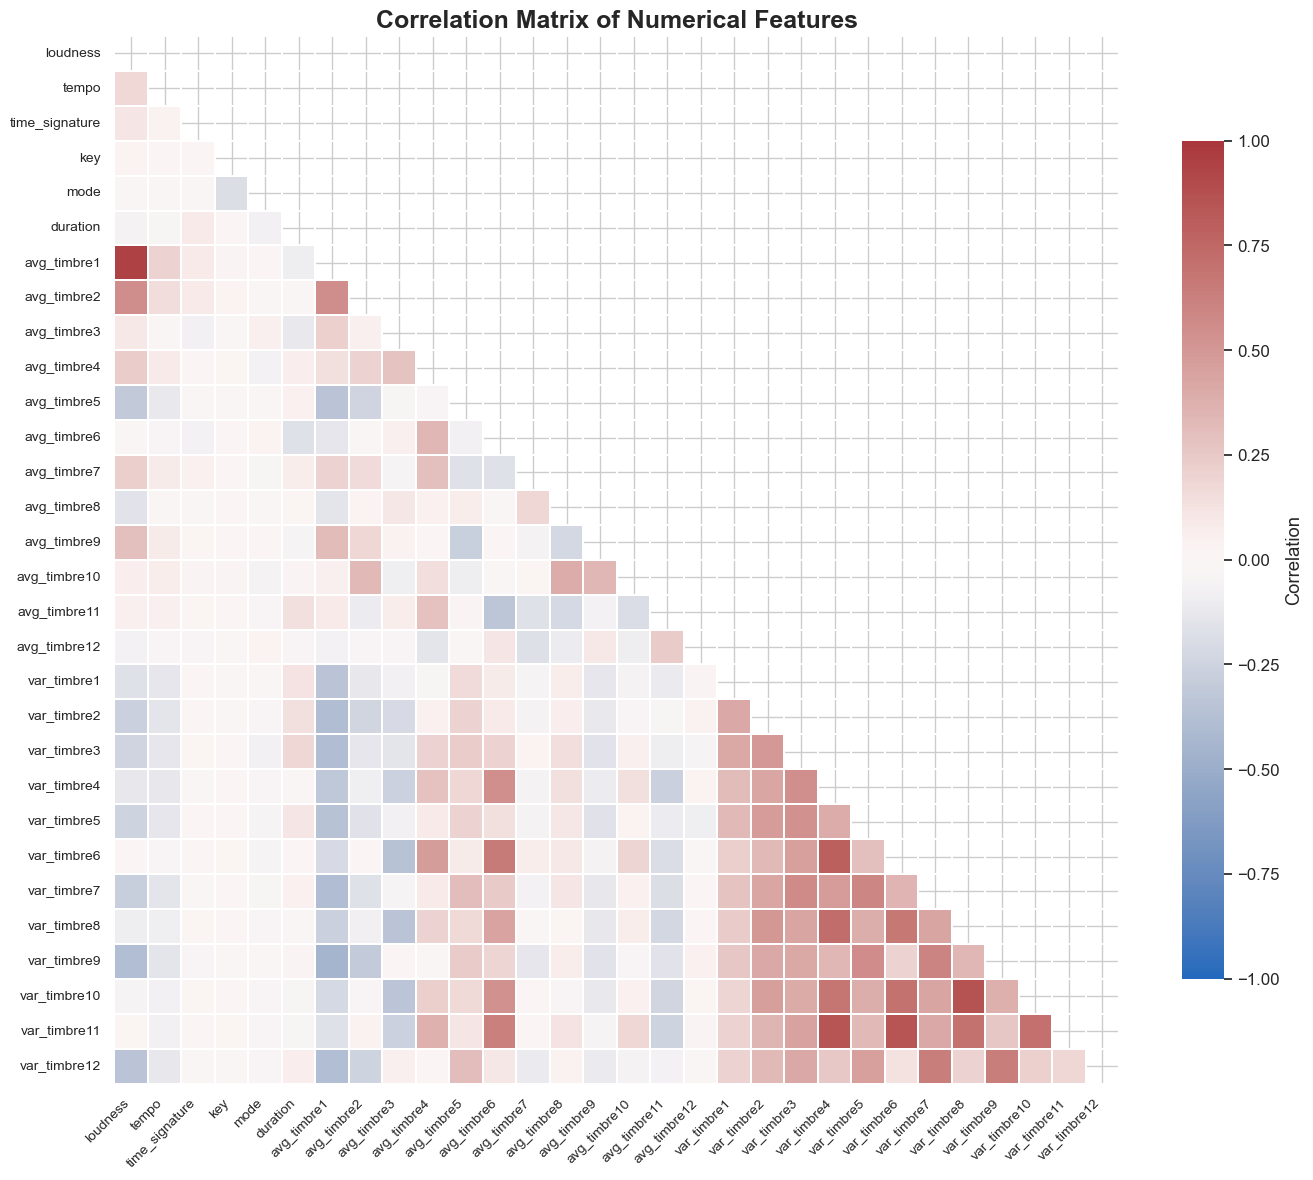

In [141]:
# Correlation heatmap (cleaner style)
plt.figure(figsize=(14, 12))

# Compute correlation on numeric columns only
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Show only the lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    cmap="vlag",              # nicer diverging palette
    annot=False,               # remove per-cell numbers to reduce clutter
    square=False,
    linewidths=0.3,
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
)

plt.title("Correlation Matrix of Numerical Features", fontsize=18, fontweight="bold")
plt.xticks(fontsize=10, rotation=45, ha="right")
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()


## Preprocessing and Train/Validation/Test Split

I drop metadata columns, encode labels, and create standardized train/validation/test splits.


In [131]:
# Preprocessing
# Drop metadata columns to isolate features
cols_to_drop = ['track_id', 'artist_name', 'title']
X = df.drop(columns=['genre'] + cols_to_drop, errors='ignore')
y = df['genre']

# Encode target labels (genres -> numbers)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split Data into train / validation / test (70% / 15% / 15%)
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded,
    test_size=0.30,
    random_state=42,
    stratify=y_encoded
)

# Second split: 15% validation, 15% test (50/50 of temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

# 4. Scale Features (fit on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Models

I train several supervised models to predict genre: Logistic Regression, Decision Tree, XGBoost, and CatBoost(extra work).


# Logistic Model

Logistic Regression Test Accuracy: 0.5698
                       precision    recall  f1-score   support

 classic pop and rock       0.55      0.80      0.65      3584
            classical       0.69      0.69      0.69       281
dance and electronica       0.58      0.40      0.47       741
                 folk       0.59      0.53      0.56      1979
              hip-hop       0.27      0.05      0.08        65
       jazz and blues       0.61      0.33      0.43       650
                metal       0.72      0.62      0.66       315
                  pop       0.00      0.00      0.00       243
                 punk       0.65      0.36      0.46       480
      soul and reggae       0.42      0.19      0.26       602

             accuracy                           0.57      8940
            macro avg       0.51      0.40      0.43      8940
         weighted avg       0.56      0.57      0.54      8940

Top 5 Features (Logistic Regression):
loudness: 1.1913
avg_timbre1: 1.034

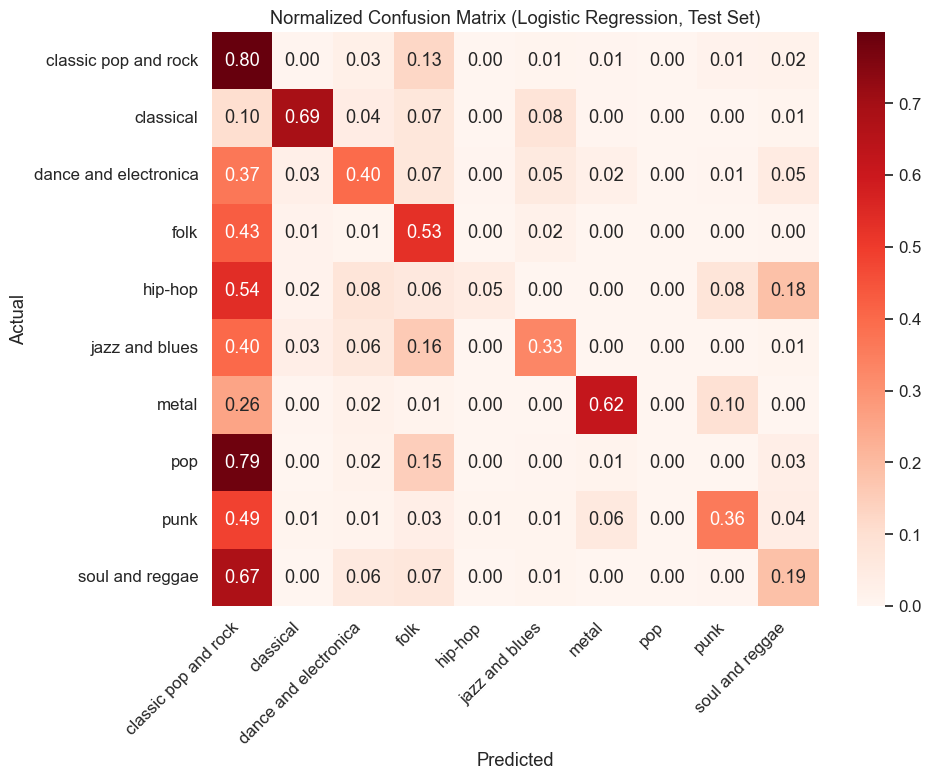

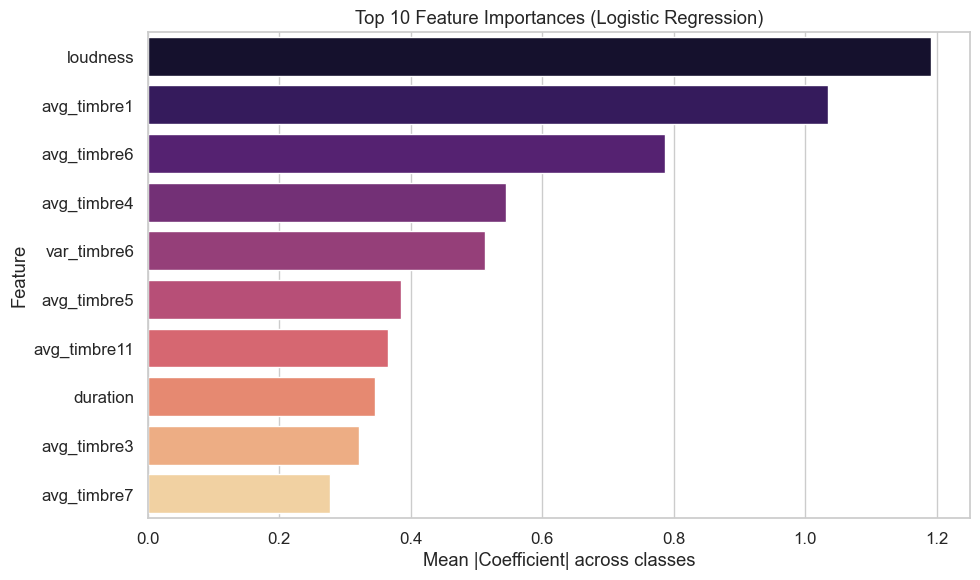

In [132]:
# Train Model on training set (no class weighting)
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=2000,
    random_state=42
)
log_reg.fit(X_train_scaled, y_train)


# Evaluate on test set
y_test_pred = log_reg.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Logistic Regression Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


# 6. Plot **normalized** Confusion Matrix for Test set
cm = confusion_matrix(y_test, log_reg.predict(X_test_scaled), normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Normalized Confusion Matrix (Logistic Regression, Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Print top 5 features by importance for logistic regression model
if hasattr(log_reg, 'coef_'):
    import numpy as np
    coef_importance = np.mean(np.abs(log_reg.coef_), axis=0)
    top5_idx = np.argsort(coef_importance)[::-1][:5]
    feature_names = X.columns
    print("Top 5 Features (Logistic Regression):")
    for idx in top5_idx:
        print(f"{feature_names[idx]}: {coef_importance[idx]:.4f}")

    # Figure: bar plot for feature importance (top 10)
    top_k = 10
    topk_idx = np.argsort(coef_importance)[::-1][:top_k]
    topk_features = feature_names[topk_idx]
    topk_values = coef_importance[topk_idx]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=topk_values, y=topk_features, orient='h', palette='magma')
    plt.title('Top 10 Feature Importances (Logistic Regression)')
    plt.xlabel('Mean |Coefficient| across classes')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [137]:
from sklearn.metrics import f1_score

f1_macro = f1_score(y_test, y_test_pred, average='macro')
print(f"Logistic Regression F1 Macro: {f1_macro:.4f}")

Logistic Regression F1 Macro: 0.4265


## Decision Tree

Decision Tree Accuracy: 0.4391
                       precision    recall  f1-score   support

 classic pop and rock       0.54      0.53      0.53      3584
            classical       0.55      0.57      0.56       281
dance and electronica       0.33      0.34      0.34       741
                 folk       0.45      0.46      0.46      1979
              hip-hop       0.10      0.09      0.10        65
       jazz and blues       0.34      0.35      0.34       650
                metal       0.49      0.47      0.48       315
                  pop       0.07      0.07      0.07       243
                 punk       0.33      0.33      0.33       480
      soul and reggae       0.25      0.24      0.25       602

             accuracy                           0.44      8940
            macro avg       0.35      0.34      0.35      8940
         weighted avg       0.44      0.44      0.44      8940

Top 5 Features:
avg_timbre2: 0.0628
duration: 0.0599
avg_timbre1: 0.0478
avg_timbre6

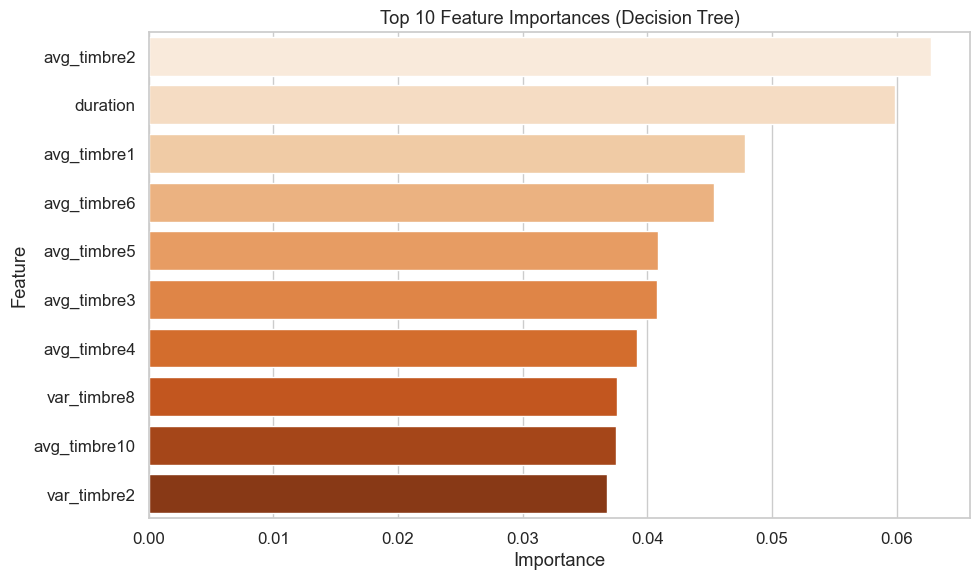

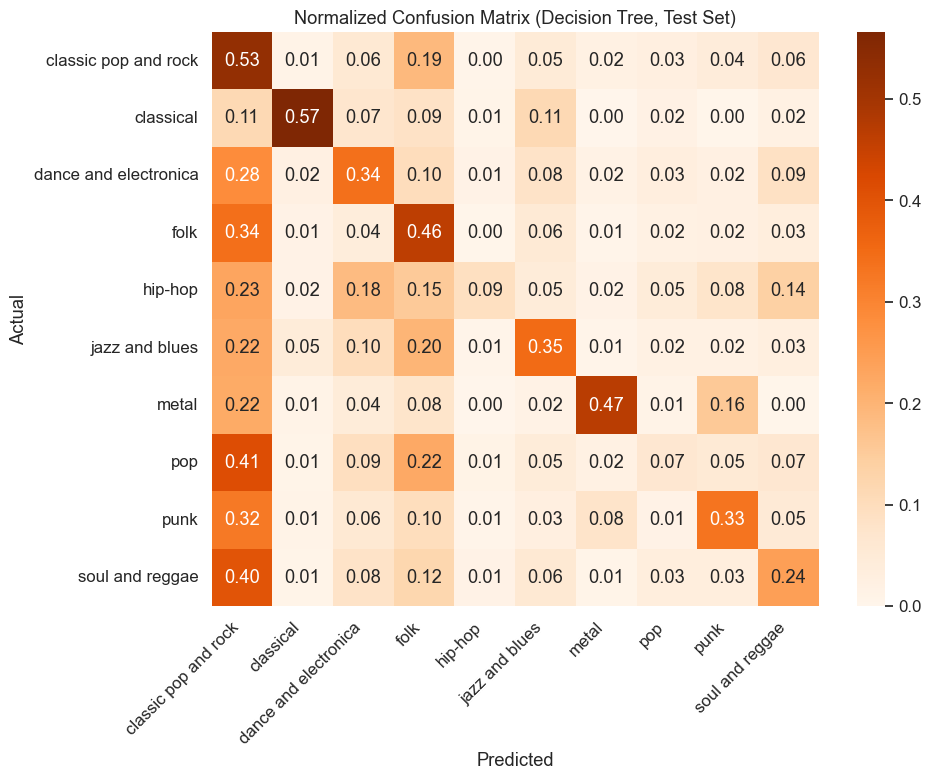

In [133]:
# Train Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Evaluate
y_pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Decision Tree Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Feature Importance
importances = dt_clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("Top 5 Features:")
for i in range(5):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Bar plot of top 10 feature importances for Decision Tree
top_k_dt = 10
topk_idx_dt = indices[:top_k_dt]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[topk_idx_dt], y=feature_names[topk_idx_dt], orient='h', palette='Oranges')
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dt, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Normalized Confusion Matrix (Decision Tree, Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [138]:
from sklearn.metrics import f1_score

# Compute macro F1 score for Decision Tree predictions
f1_macro_dt = f1_score(y_test, y_pred, average='macro')
print(f"Decision Tree Macro F1 Score: {f1_macro_dt:.4f}")

Decision Tree Macro F1 Score: 0.3452


## XG boost

XGBoost Accuracy: 0.6228
                       precision    recall  f1-score   support

 classic pop and rock       0.60      0.79      0.68      3584
            classical       0.85      0.74      0.79       281
dance and electronica       0.60      0.53      0.56       741
                 folk       0.63      0.62      0.63      1979
              hip-hop       0.50      0.14      0.22        65
       jazz and blues       0.69      0.48      0.57       650
                metal       0.81      0.64      0.71       315
                  pop       0.50      0.07      0.12       243
                 punk       0.70      0.44      0.54       480
      soul and reggae       0.52      0.27      0.36       602

             accuracy                           0.62      8940
            macro avg       0.64      0.47      0.52      8940
         weighted avg       0.62      0.62      0.61      8940

Top 5 Features (XGBoost):
avg_timbre1: 0.0720
avg_timbre2: 0.0595
loudness: 0.0591
avg_tim

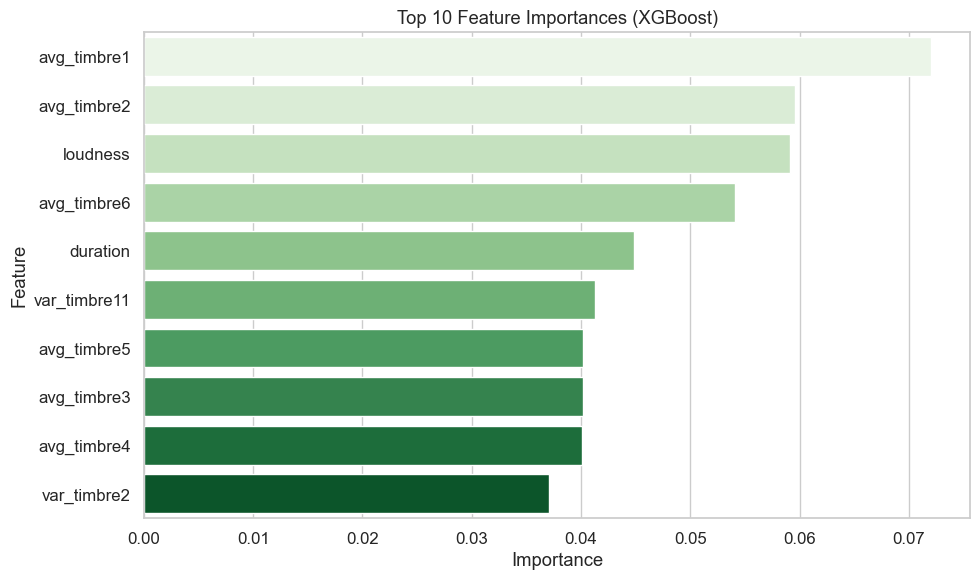

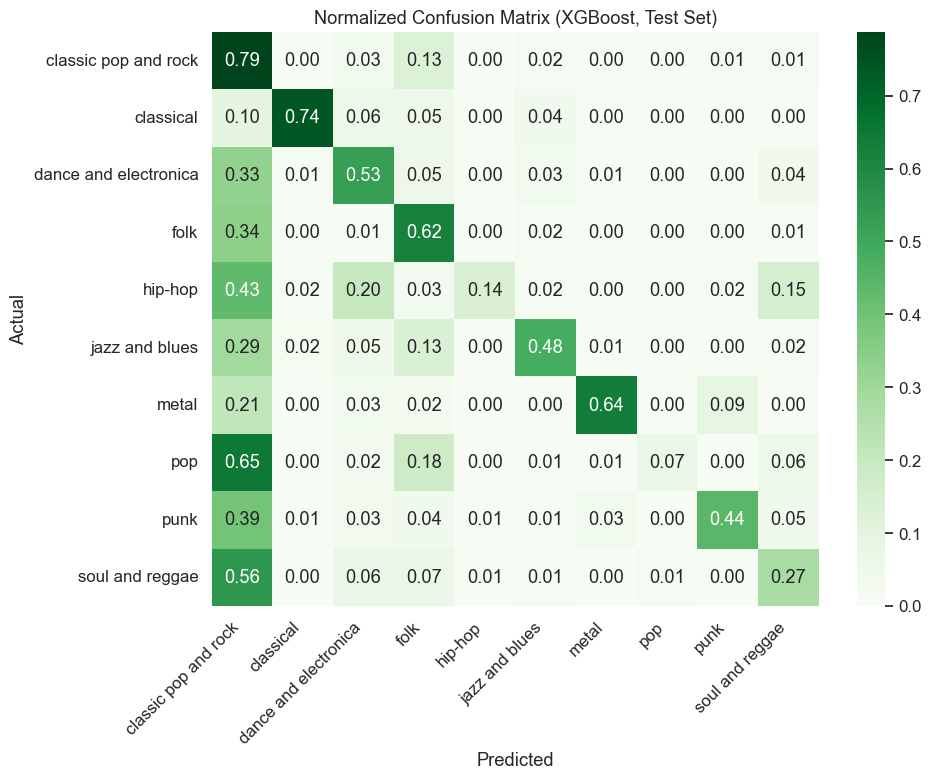

In [134]:
# Train XGBoost Classifier
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_clf.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

# Feature Importance
importances_xgb = xgb_clf.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
feature_names = X.columns

print("Top 5 Features (XGBoost):")
for i in range(5):
    print(f"{feature_names[indices_xgb[i]]}: {importances_xgb[indices_xgb[i]]:.4f}")

# Bar plot of top 10 feature importances for XGBoost
top_k_xgb = 10
topk_idx_xgb = indices_xgb[:top_k_xgb]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_xgb[topk_idx_xgb], y=feature_names[topk_idx_xgb], orient='h', palette='Greens')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Normalized Confusion Matrix (XGBoost, Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


In [139]:
# F1 macro for XGBoost
from sklearn.metrics import f1_score

f1_macro_xgb = f1_score(y_test, y_pred_xgb, average='macro')
print(f"XGBoost F1 Macro Score: {f1_macro_xgb:.4f}")

XGBoost F1 Macro Score: 0.5185


## SHAP

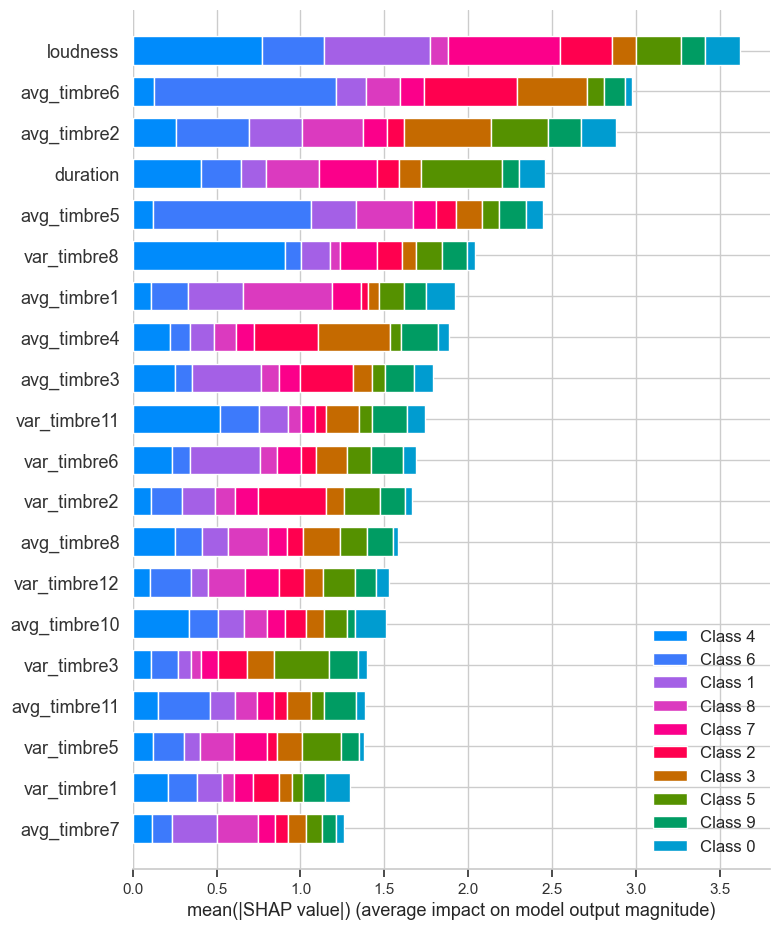

<Figure size 1200x900 with 0 Axes>

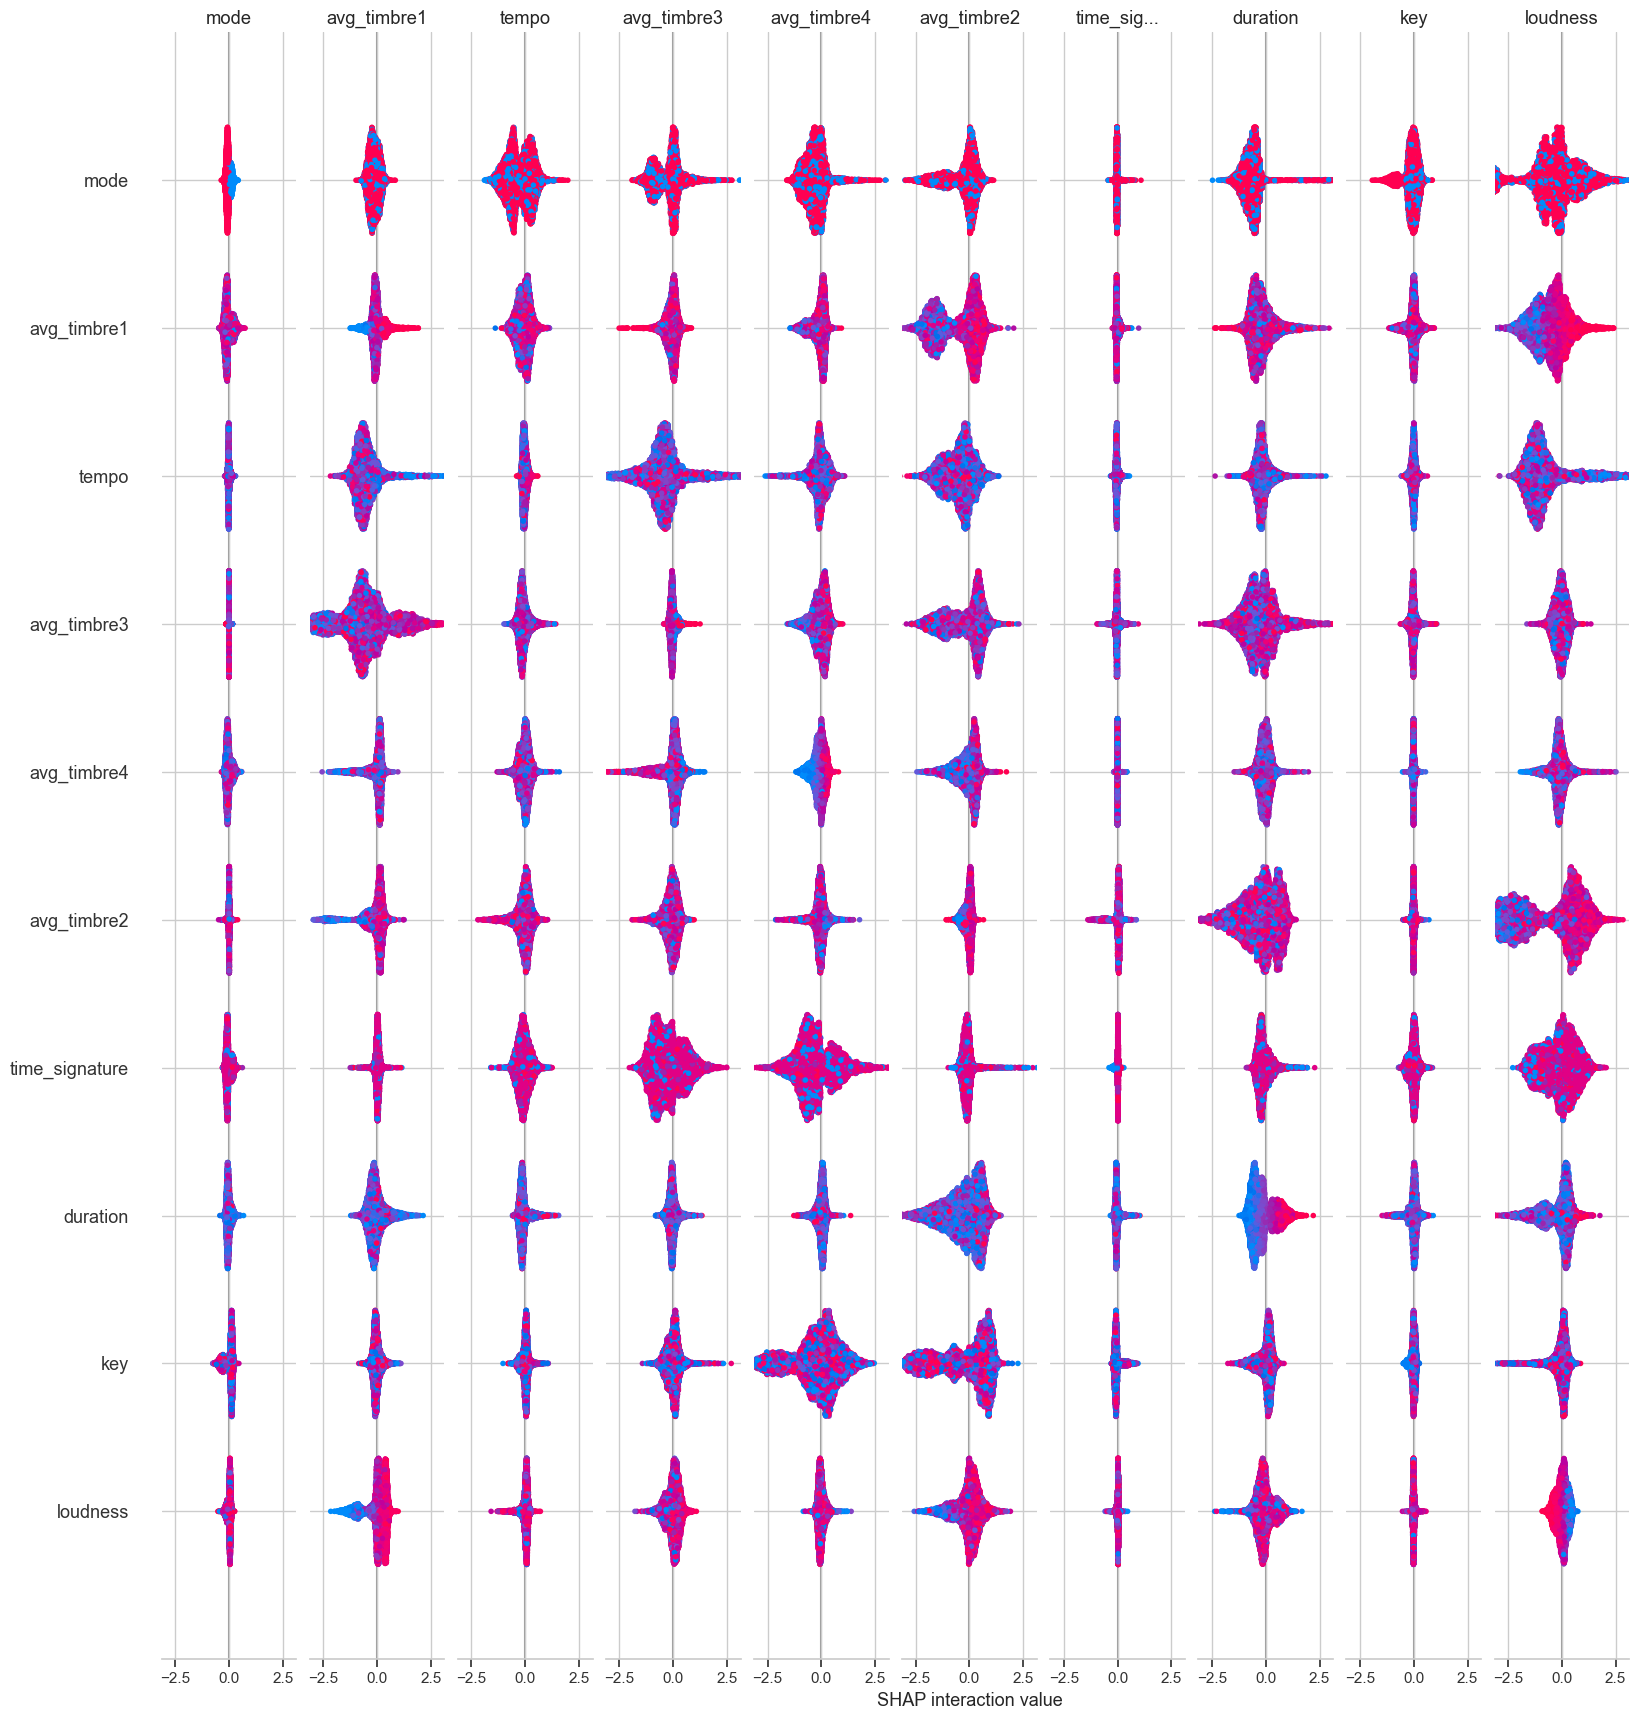

In [140]:
# SHAP (SHapley Additive exPlanations) summary plot for XGBoost

import shap

# Fit an explainer using the XGBoost model
explainer_xgb = shap.TreeExplainer(xgb_clf)
# Compute SHAP values for the test set
shap_values_xgb = explainer_xgb.shap_values(X_test)

# SHAP summary plot for top 20 features (automatic if too many features)
plt.figure(figsize=(12, 7))
shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns, plot_type="bar", max_display=20)

# Detailed SHAP summary plot (beeswarm)
plt.figure(figsize=(12, 9))
shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns, max_display=20)

## CatBoost Model

### This part is what I did for extra so not including in the final report. Train a gradient boosting model using CatBoost and inspect its accuracy and feature importances.


CatBoost Accuracy: 0.6371
                       precision    recall  f1-score   support

 classic pop and rock       0.61      0.80      0.69      4182
            classical       0.81      0.72      0.77       328
dance and electronica       0.60      0.53      0.56       863
                 folk       0.65      0.64      0.65      2309
              hip-hop       0.50      0.18      0.27        76
       jazz and blues       0.71      0.50      0.59       758
                metal       0.80      0.66      0.73       368
                  pop       0.52      0.08      0.14       283
                 punk       0.70      0.47      0.56       560
      soul and reggae       0.58      0.32      0.41       703

             accuracy                           0.64     10430
            macro avg       0.65      0.49      0.54     10430
         weighted avg       0.64      0.64      0.62     10430

Top 5 Features (CatBoost):
avg_timbre2: 6.4005
avg_timbre6: 5.7578
duration: 5.7451
loudn

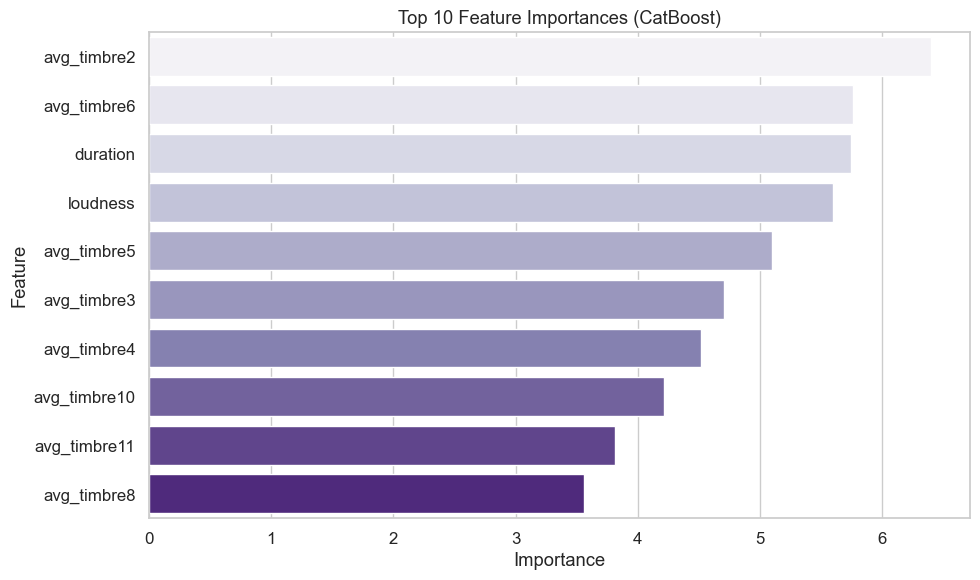

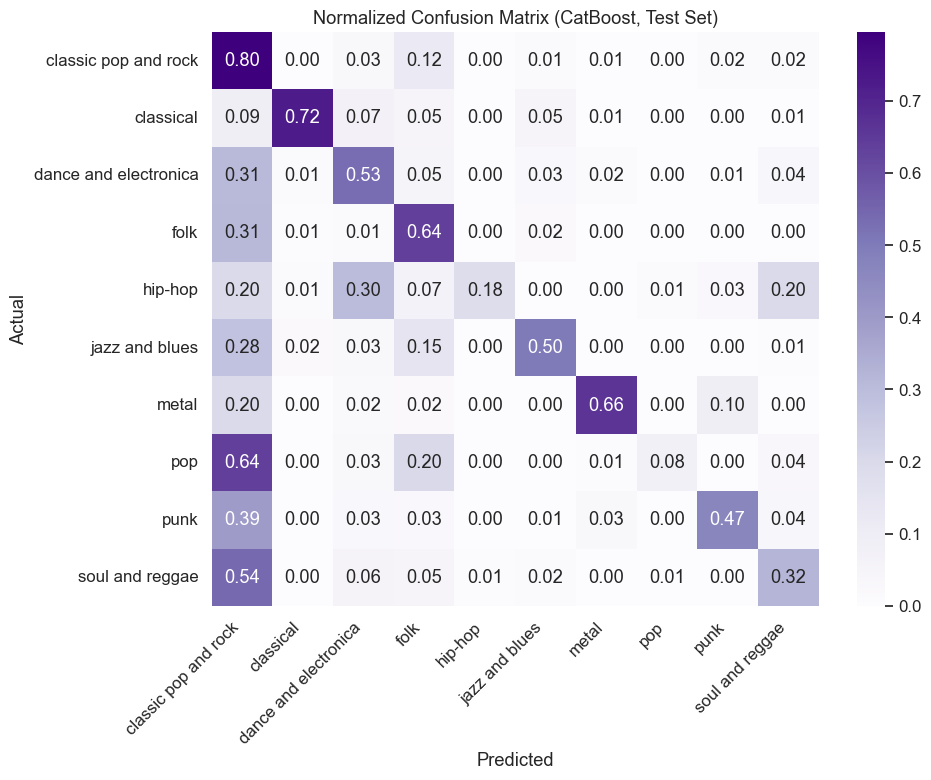

In [122]:
# Train CatBoost Classifier

from catboost import CatBoostClassifier

catboost_clf = CatBoostClassifier(
    random_seed=42, 
    verbose=0
)
catboost_clf.fit(X_train, y_train)

# Evaluate
y_pred_catboost = catboost_clf.predict(X_test)
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)

print(f"CatBoost Accuracy: {accuracy_catboost:.4f}")
print(classification_report(y_test, y_pred_catboost, target_names=le.classes_))

# Feature Importance
importances_catboost = catboost_clf.feature_importances_
indices_catboost = np.argsort(importances_catboost)[::-1]
feature_names = X.columns

print("Top 5 Features (CatBoost):")
for i in range(5):
    print(f"{feature_names[indices_catboost[i]]}: {importances_catboost[indices_catboost[i]]:.4f}")

# Bar plot of top 10 feature importances for CatBoost
top_k_cb = 10
topk_idx_cb = indices_catboost[:top_k_cb]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_catboost[topk_idx_cb], y=feature_names[topk_idx_cb], orient='h', palette='Purples')
plt.title('Top 10 Feature Importances (CatBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix for CatBoost
cm_catboost = confusion_matrix(y_test, y_pred_catboost, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm_catboost, annot=True, fmt='.2f', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Normalized Confusion Matrix (CatBoost, Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


# Evaluation and Additional Experiments

In this section I compare models on a validation set, run a feature ablation experiment, and explore SMOTE to handle class imbalance.


In [127]:
# Evaluate Logistic Regression on validation set
y_val_pred_logreg = log_reg.predict(X_val_scaled)
val_accuracy_logreg = accuracy_score(y_val, y_val_pred_logreg)
print(f"Logistic Regression Validation Accuracy: {val_accuracy_logreg:.4f}")

# Evaluate Decision Tree on validation set (model is dt_clf above)
y_val_pred_tree = dt_clf.predict(X_val)
val_accuracy_tree = accuracy_score(y_val, y_val_pred_tree)
print(f"Decision Tree Validation Accuracy: {val_accuracy_tree:.4f}")

# Evaluate XGBoost on validation set (model is xgb_clf above)
y_val_pred_xgb = xgb_clf.predict(X_val)
val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
print(f"XGBoost Validation Accuracy: {val_accuracy_xgb:.4f}")

# Evaluate CatBoost on validation set
y_val_pred_catboost = catboost_clf.predict(X_val)
val_accuracy_catboost = accuracy_score(y_val, y_val_pred_catboost)
print(f"CatBoost Validation Accuracy: {val_accuracy_catboost:.4f}")



Logistic Regression Validation Accuracy: 0.5600
Decision Tree Validation Accuracy: 0.4326
XGBoost Validation Accuracy: 0.6184
CatBoost Validation Accuracy: 0.6262


## Experiment: Should we keep the feature 'avg_timbre1'?

I'll test whether removing 'avg_timbre1' significantly impacts model performance


In [92]:
# 1. Create feature sets without 'avg_timbre1'
# Convert scaled arrays back to DataFrames so we can drop by column name
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

X_train_dropped = X_train_scaled_df.drop(columns=['avg_timbre1'])
X_test_dropped = X_test_scaled_df.drop(columns=['avg_timbre1'])

# 2. Train Logistic Regression (Dropped Feature)
log_reg_dropped = LogisticRegression(max_iter=2000, random_state=42)
log_reg_dropped.fit(X_train_dropped, y_train)

# 3. Evaluate
y_pred_dropped = log_reg_dropped.predict(X_test_dropped)
acc_dropped = accuracy_score(y_test, y_pred_dropped)

# 4. Compare with your original baseline
print(f"Original Logistic Regression Accuracy: {test_accuracy:.4f}")
print(f"Accuracy without avg_timbre1: {acc_dropped:.4f}")

if acc_dropped >= test_accuracy:
    print("Result: You CAN drop it. The model performs as well or better.")
else:
    print("Result: KEEP it. The feature adds valuable signal despite correlation.")

Original Logistic Regression Accuracy: 0.5698
Accuracy without avg_timbre1: 0.5636
Result: KEEP it. The feature adds valuable signal despite correlation.


## SMOTE
To address the issue of class imbalance in the dataset, we apply SMOTE (Synthetic Minority Over-sampling Technique). SMOTE generates synthetic samples for minority classes in the training set, which helps to create a more balanced class distribution. This can improve model performance, especially for under-represented genres.

In [135]:
from imblearn.over_sampling import SMOTE

# Create SMOTE instance
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE Resampling:")
print(pd.Series(y_train_resampled).value_counts())

# 1. Logistic Regression with SMOTE
log_reg_smote = LogisticRegression(max_iter=2000, random_state=42)
log_reg_smote.fit(X_train_resampled, y_train_resampled)
y_pred_logreg_smote = log_reg_smote.predict(X_test_scaled)
acc_logreg_smote = accuracy_score(y_test, y_pred_logreg_smote)
print(f"Logistic Regression (SMOTE) Test Accuracy: {acc_logreg_smote:.4f}")

# 2. Decision Tree with SMOTE
dt_clf_smote = DecisionTreeClassifier(random_state=42)
dt_clf_smote.fit(X_train_resampled, y_train_resampled)
y_pred_tree_smote = dt_clf_smote.predict(X_test_scaled)
acc_tree_smote = accuracy_score(y_test, y_pred_tree_smote)
print(f"Decision Tree (SMOTE) Test Accuracy: {acc_tree_smote:.4f}")

# 3. XGBoost with SMOTE
xgb_clf_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf_smote.fit(X_train_resampled, y_train_resampled)
y_pred_xgb_smote = xgb_clf_smote.predict(X_test_scaled)
acc_xgb_smote = accuracy_score(y_test, y_pred_xgb_smote)
print(f"XGBoost (SMOTE) Test Accuracy: {acc_xgb_smote:.4f}")

# 4. CatBoost with SMOTE
catboost_clf_smote = CatBoostClassifier(verbose=0, random_state=42)
catboost_clf_smote.fit(X_train_resampled, y_train_resampled)
y_pred_catboost_smote = catboost_clf_smote.predict(X_test_scaled)
acc_catboost_smote = accuracy_score(y_test, y_pred_catboost_smote)
print(f"CatBoost (SMOTE) Test Accuracy: {acc_catboost_smote:.4f}")


After SMOTE Resampling:
0    16727
8    16727
3    16727
9    16727
2    16727
5    16727
1    16727
7    16727
6    16727
4    16727
Name: count, dtype: int64
Logistic Regression (SMOTE) Test Accuracy: 0.4246
Decision Tree (SMOTE) Test Accuracy: 0.3762
XGBoost (SMOTE) Test Accuracy: 0.6006
CatBoost (SMOTE) Test Accuracy: 0.6093
